In [1]:
# cài đặt thư viện cần thiết
!pip install sklearn fuzzy-c-means

You should consider upgrading via the 'C:\Users\nvatu\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
# load thư viện cần thiết

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from fcmeans import FCM
import pickle

In [3]:
# random state
rs = 12

In [4]:
# đọc dữ liệu
df = pd.read_csv('../data/rfm_data.csv')
df

,User number,Recency,Frequency,Moneytary
0,101000281,0.161538,0.010256,0.208800
1,101000282,0.623077,0.002564,0.007971
2,101000283,0.184615,0.007692,0.015943
3,101000320,0.269231,0.000000,0.023914
4,101000325,0.200000,0.000000,0.040000
...,...,...,...,...
8938,106000005,0.053846,0.000000,0.003986
8939,106000011,0.038462,0.000000,0.003986
8940,106000012,0.038462,0.000000,0.003986
8941,106000013,0.030769,0.000000,0.003986


In [5]:
# load trọng số lên
rfm_weight = pd.read_csv('../data/rfm_weight.csv')
rfm_weight

,variable,weight
0,Recency,0.137
1,Frequency,0.328
2,Moneytary,0.535


In [6]:
# lấy trọng số ra
w = rfm_weight.set_index('variable').to_dict()['weight']
w

{'Recency': 0.137, 'Frequency': 0.328, 'Moneytary': 0.535}

In [7]:
# nhân trọng số vào mỗi cột
df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: x * w[x.name])

In [8]:
df

,User number,Recency,Frequency,Moneytary
0,101000281,0.022131,0.003364,0.111708
1,101000282,0.085362,0.000841,0.004265
2,101000283,0.025292,0.002523,0.008529
3,101000320,0.036885,0.000000,0.012794
4,101000325,0.027400,0.000000,0.021400
...,...,...,...,...
8938,106000005,0.007377,0.000000,0.002132
8939,106000011,0.005269,0.000000,0.002132
8940,106000012,0.005269,0.000000,0.002132
8941,106000013,0.004215,0.000000,0.002132


## Chuẩn bị dữ liệu

In [9]:
cust_id = df.iloc[:, 0].values
X = df.iloc[:, 1:].values
cust_id, X

(array([101000281, 101000282, 101000283, ..., 106000012, 106000013,
        106000017], dtype=int64),
 array([[0.02213077, 0.0033641 , 0.111708  ],
        [0.08536154, 0.00084103, 0.00426471],
        [0.02529231, 0.00252308, 0.00852943],
        ...,
        [0.00526923, 0.        , 0.00213236],
        [0.00421538, 0.        , 0.00213236],
        [0.        , 0.        , 0.0214    ]]))

# Phân cụm

## KMeans

In [10]:
# dùng thang đo silhouette để chọn số cụm
# để số cụm từ 3 -> 10

range_k = np.arange(2, 10)
range_k

array([2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
def make_kmean(k: int):
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X)
    cluster_labels = model.predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    print(f"K: {k} done")
    return dict(
        k=k,
        cluster_labels=cluster_labels,
        sil_score=sil_score
    )

In [12]:
kmean_final_cluster = [make_kmean(k) for k in range_k]

K: 2 done
K: 3 done
K: 4 done
K: 5 done
K: 6 done
K: 7 done
K: 8 done
K: 9 done


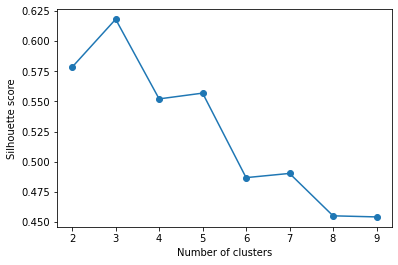

In [13]:
sil_scores = np.array([i['sil_score'] for i in kmean_final_cluster])

plt.plot(range_k, sil_scores)
plt.scatter(range_k, sil_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('Kmean sil plot.png')
plt.show()

In [14]:
# sắp xếp các mô hình KMean theo chỉ số sihouette (từ cao xuống thấp)
sorted_kmean_final_cluster = sorted(kmean_final_cluster, key=lambda x: x['sil_score'], reverse=True)

In [15]:
sorted_kmean_final_cluster

[{'k': 3,
  'cluster_labels': array([2, 1, 0, ..., 0, 0, 0]),
  'sil_score': 0.6181359981021375},
 {'k': 2,
  'cluster_labels': array([0, 1, 0, ..., 0, 0, 0]),
  'sil_score': 0.5784631317095966},
 {'k': 5,
  'cluster_labels': array([4, 3, 0, ..., 0, 0, 0]),
  'sil_score': 0.5569057215833989},
 {'k': 4,
  'cluster_labels': array([2, 3, 0, ..., 0, 0, 0]),
  'sil_score': 0.5521189824373747},
 {'k': 7,
  'cluster_labels': array([4, 1, 0, ..., 0, 0, 0]),
  'sil_score': 0.49035701976734564},
 {'k': 6,
  'cluster_labels': array([0, 5, 3, ..., 3, 3, 3]),
  'sil_score': 0.486858400762372},
 {'k': 8,
  'cluster_labels': array([3, 1, 0, ..., 6, 6, 6]),
  'sil_score': 0.45521090934801123},
 {'k': 9,
  'cluster_labels': array([5, 6, 1, ..., 1, 1, 1]),
  'sil_score': 0.45430303127450483}]

In [16]:
# lấy mô hình có giá trị sihouette tốt nhất

best_k_kmean = sorted_kmean_final_cluster[0]['k']
kmean_cluster_labels = sorted_kmean_final_cluster[0]['cluster_labels']
kmean_sil_score = sorted_kmean_final_cluster[0]['sil_score']
print(f'Số cụm tốt nhất cho KMeans là {best_k_kmean} với giá trị sihouette: {kmean_sil_score}')

Số cụm tốt nhất cho KMeans là 3 với giá trị sihouette: 0.6181359981021375


In [17]:
# chạy lại model
print(f"Chạy lại model với K = {best_k_kmean} cho K Means")
kmean_model = KMeans(n_clusters=best_k_kmean, random_state=rs)
kmean_model.fit(X)

Chạy lại model với K = 3 cho K Means


KMeans(n_clusters=3, random_state=12)

In [18]:
# Lưu lại mô hình
with open('../data/kmean_model.pkl', 'wb') as f:
    pickle.dump(kmean_model, f, pickle.HIGHEST_PROTOCOL)

In [19]:
kmean_cluster_df = pd.DataFrame(
    {'User number': cust_id, 'Cluster Label': kmean_cluster_labels}
)
df_merged_kmean = df.merge(kmean_cluster_df, on='User number')
df_merged_kmean.to_csv('../data/cluster_kmeans.csv', index=False)

In [20]:
print("Trung bình giá trị trên mỗi cụm của KMeans")
df_merged_kmean.groupby('Cluster Label').mean().iloc[:, 1:]

Trung bình giá trị trên mỗi cụm của KMeans


,Recency,Frequency,Moneytary
Cluster Label,,,
0,0.029525,0.001074,0.008370
1,0.100743,0.000246,0.008219
2,0.047626,0.009916,0.157928


In [21]:
print("Số lượng khách hàng mỗi cụm")
kmean_cluster_df.groupby('Cluster Label').count()

Số lượng khách hàng mỗi cụm


,User number
Cluster Label,
0,5011
1,3693
2,239


### Fuzzy C-Mean

In [22]:
def make_fuzzycmean(k: int):
    model = FCM(n_clusters=k, random_state=rs)
    model.fit(X)
    cluster_labels = model.predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    print(f"K: {k} done")
    return dict(
        k=k,
        cluster_labels=cluster_labels,
        sil_score=sil_score
    )

In [23]:
fuzzycmean_final_cluster = [make_fuzzycmean(k) for k in range_k]

K: 2 done
K: 3 done
K: 4 done
K: 5 done
K: 6 done
K: 7 done
K: 8 done
K: 9 done


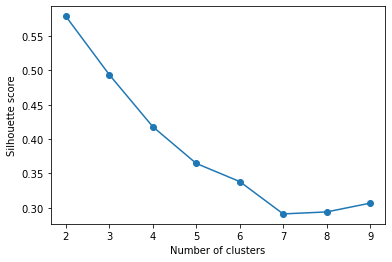

In [24]:
sil_scores = np.array([i['sil_score'] for i in fuzzycmean_final_cluster])

plt.plot(range_k, sil_scores)
plt.scatter(range_k, sil_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('Fuzzy C-Mean sil plot.png')
plt.show()

In [25]:
# sắp xếp các mô hình Fuzzy C Mean theo chỉ số sihouette (từ cao xuống thấp)
sorted_fuzzycmean_final_cluster = sorted(fuzzycmean_final_cluster, key=lambda x: x['sil_score'], reverse=True)

In [26]:
sorted_fuzzycmean_final_cluster

[{'k': 2,
  'cluster_labels': array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
  'sil_score': 0.5789777789768532},
 {'k': 3,
  'cluster_labels': array([1, 2, 1, ..., 1, 1, 1], dtype=int64),
  'sil_score': 0.4938707780267614},
 {'k': 4,
  'cluster_labels': array([2, 3, 2, ..., 2, 2, 2], dtype=int64),
  'sil_score': 0.4181322240879449},
 {'k': 5,
  'cluster_labels': array([1, 0, 4, ..., 1, 1, 1], dtype=int64),
  'sil_score': 0.3645713327878833},
 {'k': 6,
  'cluster_labels': array([1, 5, 3, ..., 1, 1, 1], dtype=int64),
  'sil_score': 0.3381861051777119},
 {'k': 9,
  'cluster_labels': array([8, 4, 5, ..., 1, 1, 1], dtype=int64),
  'sil_score': 0.30669995577382436},
 {'k': 8,
  'cluster_labels': array([3, 0, 1, ..., 3, 3, 3], dtype=int64),
  'sil_score': 0.2939248378497759},
 {'k': 7,
  'cluster_labels': array([6, 1, 2, ..., 6, 6, 6], dtype=int64),
  'sil_score': 0.2910190116229502}]

In [27]:
# lấy mô hình có giá trị sihouette tốt nhất

best_k_fuzzycmean = sorted_fuzzycmean_final_cluster[0]['k']
fuzzycmean_cluster_labels = sorted_fuzzycmean_final_cluster[0]['cluster_labels']
fuzzycmean_sil_score = sorted_fuzzycmean_final_cluster[0]['sil_score']
print(f'Số cụm tốt nhất cho KMeans là {best_k_fuzzycmean} với giá trị sihouette: {fuzzycmean_sil_score}')

Số cụm tốt nhất cho KMeans là 2 với giá trị sihouette: 0.5789777789768532


In [28]:
# chạy lại model
print(f"Chạy lại model với K = {best_k_fuzzycmean} cho Fuzzy C-Mean")
fcm_model = FCM(n_clusters=best_k_fuzzycmean, random_state=rs)
fcm_model.fit(X)

Chạy lại model với K = 2 cho Fuzzy C-Mean


In [29]:
# Lưu lại mô hình
with open('../data/fuzzycmean_model.pkl', 'wb') as f:
    pickle.dump(fcm_model, f, pickle.HIGHEST_PROTOCOL)

In [30]:
fuzzycmean_cluster_df = pd.DataFrame(
    {'User number': cust_id, 'Cluster Label': fuzzycmean_cluster_labels}
)
df_merged_fuzzy = df.merge(fuzzycmean_cluster_df, on='User number')
df_merged_fuzzy.to_csv('../data/cluster_fuzzycmean.csv', index=False)

In [31]:
print("Trung bình giá trị trên mỗi cụm của Fuzzy C-Mean")
df_merged_fuzzy.groupby('Cluster Label').mean().iloc[:, 1:]

Trung bình giá trị trên mỗi cụm của Fuzzy C-Mean


,Recency,Frequency,Moneytary
Cluster Label,,,
0,0.029398,0.001485,0.013089
1,0.100648,0.000259,0.011228


In [32]:
print("Số lượng khách hàng mỗi cụm")
fuzzycmean_cluster_df.groupby('Cluster Label').count()

Số lượng khách hàng mỗi cụm


,User number
Cluster Label,
0,5175
1,3768
